/tmp/ipython-input-2748478146.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)


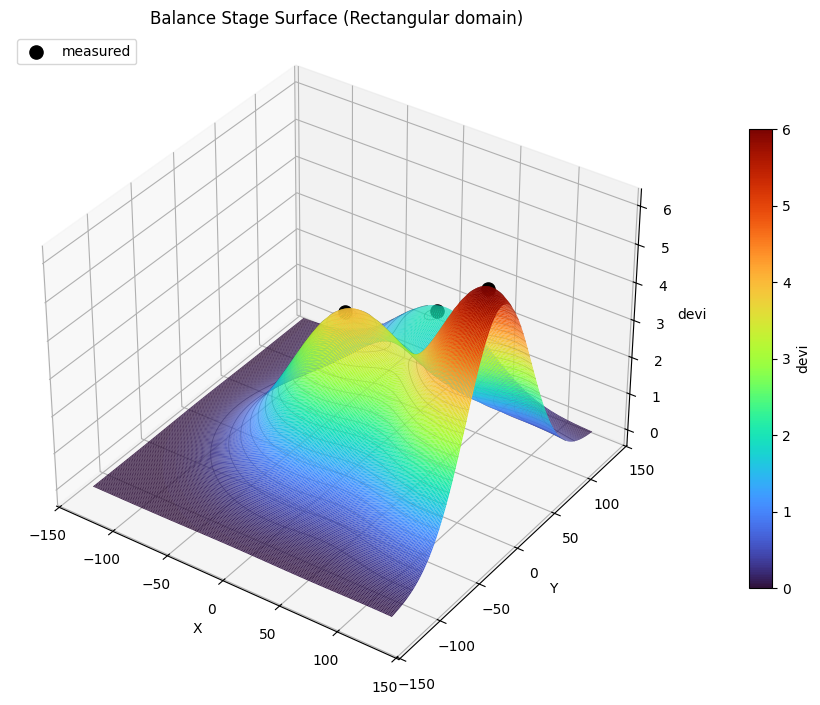

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# --------- 유틸 ---------
def pick_sigma_from_points(x, y, scale=0.35):
    """가장 가까운 두 점 거리 * scale 을 sigma로 사용"""
    n = len(x)
    dmin = np.inf
    for i in range(n):
        for j in range(i+1, n):
            d = np.hypot(x[i]-x[j], y[i]-y[j])
            if d < dmin:
                dmin = d
    return max(dmin * scale, 1e-6)

# --------- 가우시안 RBF ---------
def rbf_gaussian_weights(x, y, v, sigma, lam=1e-9):
    X = np.column_stack([x, y])
    d2 = np.sum((X[:,None,:]-X[None,:,:])**2, axis=2)
    K = np.exp(-d2/(sigma**2))
    K[np.diag_indices_from(K)] += lam  # ridge
    return np.linalg.solve(K, v)

def rbf_gaussian_eval(w, x_pts, y_pts, Xg, Yg, sigma):
    Zg = np.zeros_like(Xg, dtype=float)
    for (xj, yj), wj in zip(zip(x_pts, y_pts), w):
        d2 = (Xg - xj)**2 + (Yg - yj)**2
        Zg += wj * np.exp(-d2/(sigma**2))
    return Zg

# --------- 플로팅 ---------
def plot_rect_surface(points,
                      sigma_scale=0.70,   # ↑ 키우면 더 완만, ↓ 줄이면 더 뾰족
                      lam=1e-9,           # ↑ 키우면 더 매끈(정규화 강화)
                      grid_res=260,
                      cmap_name="turbo",
                      n_contours=24,
                      force_vmin_zero=True,
                      center_origin=True,
                      pad_ratio=0.1):
    # 원본 3점만 사용
    x, y, v = points[:,0], points[:,1], points[:,3].astype(float)

    # 그리드: 원점 대칭 사각 도메인
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    if center_origin:
        Rx = max(abs(xmin), abs(xmax)) * (1 + pad_ratio)
        Ry = max(abs(ymin), abs(ymax)) * (1 + pad_ratio)
        xi = np.linspace(-Rx, Rx, grid_res)
        yi = np.linspace(-Ry, Ry, grid_res)
    else:
        dx = (xmax - xmin) * pad_ratio
        dy = (ymax - ymin) * pad_ratio
        xi = np.linspace(xmin - dx, xmax + dx, grid_res)
        yi = np.linspace(ymin - dy, ymax + dy, grid_res)
    Xg, Yg = np.meshgrid(xi, yi)

    # RBF 표면
    sigma = pick_sigma_from_points(x, y, scale=sigma_scale)
    w = rbf_gaussian_weights(x, y, v, sigma=sigma, lam=lam)
    Zg = rbf_gaussian_eval(w, x, y, Xg, Yg, sigma=sigma)

    # 색 스케일
    if force_vmin_zero:
        vmin = 0.0
        vmax = float(np.nanmax(v))
        if vmax <= vmin: vmax = vmin + 1.0
    else:
        vmin, vmax = float(np.nanmin(Zg)), float(np.nanmax(Zg))
        if vmax - vmin < 1e-12: vmax = vmin + 1.0

    cmap = get_cmap(cmap_name)
    norm = Normalize(vmin=vmin, vmax=vmax)
    facecolors = cmap(norm(Zg))

    # 플롯
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(
        Xg, Yg, Zg,
        rstride=1, cstride=1,
        facecolors=facecolors,
        linewidth=0, antialiased=True, shade=False
    )
    try:
        ax.contour3D(Xg, Yg, Zg, levels=n_contours,
                     linewidths=0.6, colors="k", alpha=0.45)
    except Exception:
        pass

    ax.scatter(x, y, v, s=90, c="k", depthshade=False, label="measured")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("devi")
    ax.set_title("Balance Stage Surface (Rectangular domain)")
    try:
        ax.set_box_aspect((xi.ptp(), yi.ptp(), max(vmax - vmin, 1.0)))
    except Exception:
        pass
    ax.view_init(elev=35, azim=-55)

    mappable = ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(Zg)
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.1)
    cbar.set_label("devi")

    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


# ===== 실제 데이터 =====
points = np.array([
    [0.0,   120.0, 1.95, 2.0],   # P1 [x, y, z, devi]
    [0.0,     0.0, 1.654, 4.0],  # P2
    [121.0,   0.0, 1.798, 6.0],  # P3
], dtype=float)

# 실행
plot_rect_surface(points,
                  sigma_scale=0.50,  # 0.2~1.5 범위에서 조절
                  lam=1e-9,          # 1e-9 ~ 1e-2 범위에서 조절
                  grid_res=260,
                  cmap_name="turbo",
                  n_contours=24,
                  force_vmin_zero=True,
                  center_origin=True,
                  pad_ratio=0.1)
